# Introduction

The goal of this notebook is to attempt to create an SARIMAX model to predict future sales data using the data given in https://www.kaggle.com/c/demand-forecasting-kernels-only. The main reference material used were

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

from scipy import stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = ['date'], index_col = ['date'])

In [3]:
# Separate sample data set
train1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index < '2017-10-01'), 'sales']
val1_1 = train.loc[(train['store'] == 1) & (train['item'] == 1) & (train.index >= '2017-10-01'), 'sales']

In [ ]:
# Plot training data
plt.plot(train1_1.loc[(train1_1.index >= '2017-01-01')])
plt.xticks(rotation=90)

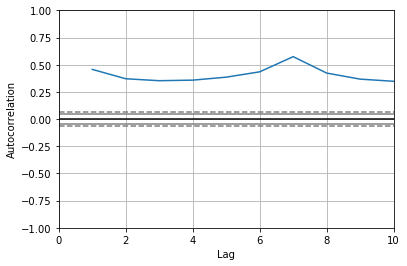

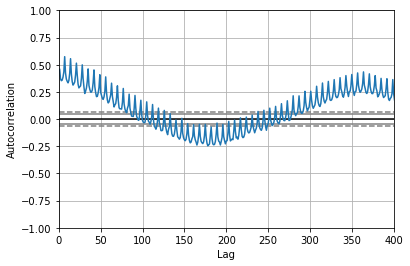

In [4]:
#Plot autocorrelation data

plt.figure(1)
autocorrelation_plot(train1_1)
plt.xlim(0, 10)
plt.figure(2)
autocorrelation_plot(train1_1)
plt.xlim(0, 400)
plt.show()

As it can be seen, there is a peak in autocorrelation with lags around 7 and 365. This is likely because there is a mixture of weekly and annual seasonal components.

# Model Fitting

/Users/Philip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1734
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 1)   Log Likelihood               -5137.292
Date:                           Thu, 20 Feb 2020   AIC                          10332.584
Time:                                   14:25:02   BIC                          10490.586
Sample:                               01-01-2013   HQIC                         10391.048
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9273      5.048     -0.184      0.854     -10.822       8.967
ar.L2         -0.9082      5.737     -0.158

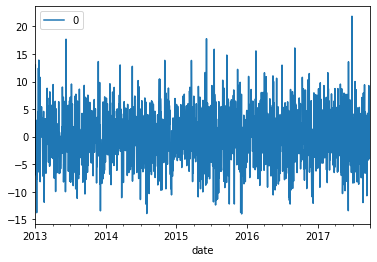

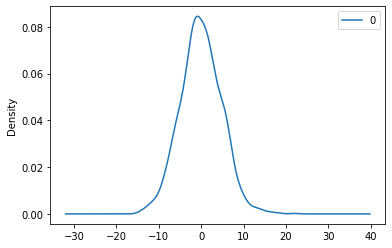

                 0
count  1734.000000
mean     -0.023384
std       4.830685
min     -14.030476
25%      -3.135770
50%      -0.123872
75%       3.134116
max      21.860007


In [5]:
# Fit model on SARIMAX
model = SARIMAX(train1_1, order = (7,1,7), seasonal_order = (7,1,7,1), freq = 'D',
                enforce_stationarity = False, enforce_invertibility=False)
model_fit = model.fit(disp = 0)
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind = 'kde')
plt.show()
print(residuals.describe())

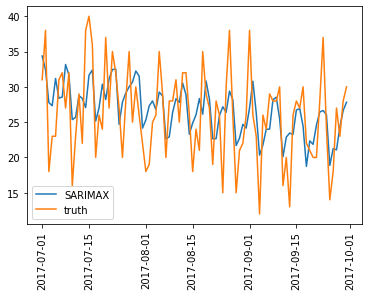

In [16]:
prediction = model_fit.predict(len(train1_1)-92,len(train1_1)-1)
plt.plot(prediction)
plt.xticks(rotation=90)
plt.plot(train1_1.loc[(train1_1.index >= '2017-07-01')])
plt.legend(['SARIMAX', 'truth'])

In [7]:
model = SARIMAX(train1_1, order = (7,1,7), seasonal_order = (7,1,7,1), freq = 'D')
model_fit = model.fit(disp=0)
#output = model_fit.predict(start = '2017-09-01', end = '2017-12-31', dynamic = True)
predictions = model_fit.forecast(steps = len(val1_1))

/Users/Philip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Philip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/Philip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [8]:
def SMAPE(y_true, y_pred):
    """ Returns the standard mean absolute percent error in %
    """
    return np.mean(200*np.abs(y_pred - y_true)/(np.abs(y_pred)+np.abs(y_true)))

Validation MSE: 30.264
Validation SMAPE: 23.545%


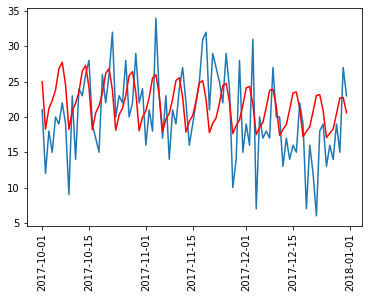

In [9]:
predictions = pd.Series(predictions)

error = mean_squared_error(val1_1, predictions)
print('Validation MSE: {:.3f}'.format(error))
print('Validation SMAPE: {:.3f}%'.format(SMAPE(val1_1, predictions)))
# plot
plt.plot(val1_1)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

# Conclusion

With an SMAPE of 23.5% and a mean squared error of 30.3, the SARIMAX model does considerably better than a plain ARIMA model for there is a seasonal component to the data. For this Kaggle competition, the SARIMAX fit and forecasting steps would half to be completed 500 times with no relations found between each of the trends. Next is an attempt to use an LSTM network to try to fit the data.